In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import dblquad, quad, simps
from scipy.special import erf
from tqdm.notebook import tqdm
from multiprocessing import Pool
import itertools

from fproject_get_data import preprocess_and_save_data, load_and_plot_data

In [2]:
plt.rc("figure", dpi=150)
plt.rc("legend", fontsize=6)

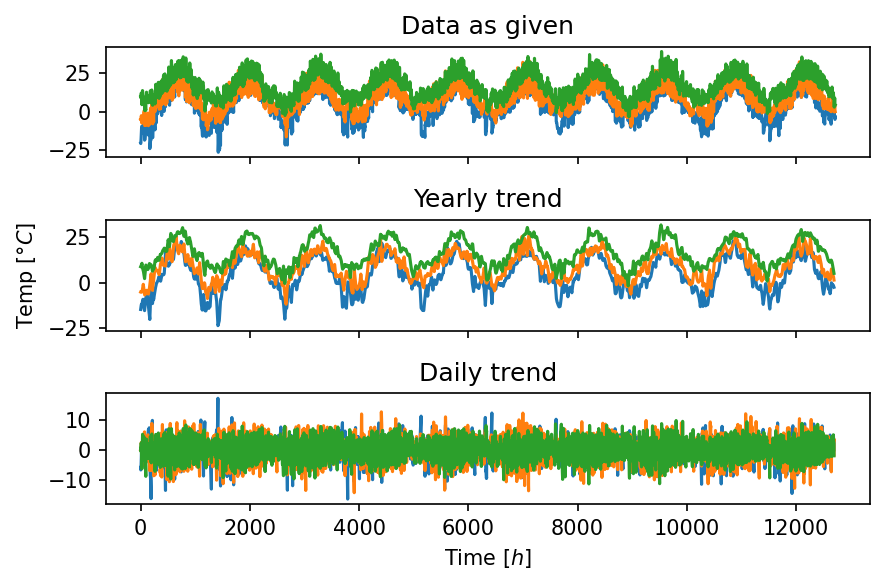

In [3]:
#preprocess_and_save_data()
npa, mnpa = load_and_plot_data()

In [4]:
ratio = 0.8
x_train = mnpa[:int(ratio*len(mnpa))]
x_test = mnpa[int(ratio*len(mnpa)):]

In [5]:
class Probabilistic_RNN():
    def __init__(self, A, Sigma, mu0, B, Gamma):
        self.set_parameters(A, Sigma, mu0, B, Gamma)
        self.latent_dim = Sigma.shape[0]
        self.obs_dim = Gamma.shape[0]
        
    def set_parameters(self, A, Sigma, mu0, B, Gamma):
        self.A = A
        self.Sigma = Sigma
        self.mu0 = mu0
        self.B = B
        self.Gamma = Gamma
        
    def get_parameters(self):
        return {
            "A": self.A,
            "Sigma": self.Sigma,
            "mu0": self.mu0,
            "B": self.B,
            "Gamma": self.Gamma
        }
        
    def generate_time_series(self, T):
        z = np.zeros(shape=(T, self.latent_dim))
        x = np.zeros(shape=(T, self.obs_dim))
        
        epsilon = np.random.multivariate_normal(np.zeros(self.latent_dim), self.Sigma, size=T)
        eta = np.random.multivariate_normal(np.zeros(self.obs_dim), self.Gamma, size=T)

        
        z[0] = np.random.multivariate_normal(self.mu0, self.Sigma)
        x[0] = self.B @ z[0] + eta[0]
        
        for t in range(1, T):
            z[t] = self.A @ np.maximum(z[t-1], 0) + epsilon[t]
            x[t] = self.B @ z[t] + eta[t]
            
        return z, x
    
    def estimate_parameters(self, x, E_z, E_zz, E_zphiz1, E_phizphiz):
        """
        x = observed time series of shape (T, obs_dim)
        E_z = (E[z_t])_t of shape (T, latent_dim)
        E_zz = (E[z_t @ z_t^T])_t of shape(T, latent_dim, latent_dim)
        E_zphiz1 = (E[z_t @ phi(z_{t-1})^T])_t of shape (T-1, latent_idm, latent_dim)
        """
        T = len(x)
        
        #A_new = np.sum(E_zphiz1, axis=0) @ np.linalg.inv(np.sum(E_zz[:-1], axis=0))
        A_new = np.linalg.solve(np.sum(E_phizphiz[:-1], axis=0).T, np.sum(E_zphiz1, axis=0).T).T
        
        Sigma_new = 1/T * (np.sum(E_zz[1:], axis=0) - A_new @ np.sum(E_zphiz1, axis=0).T)
        #Sigma_new = 1/T * (np.sum(E_zz[1:], axis=0) - np.sum(E_zphiz1, axis=0) @ A_new.T - A_new @ np.sum(E_zphiz1, axis=0) + A_new @ np.sum(E_phizphiz[:-1], axis=0) @ A_new.T)
        #Sigma_new += 1e-3 * np.eye(Sigma_new.shape[0])
        Sigma_new = np.diag(np.diag(Sigma_new))
        Sigma_new = np.abs(Sigma_new)
        
        mu0_new = E_z[0]
        
        sum_t_x_Ez = np.einsum("ij,il->jl", x, E_z)
        
        #B_new = sum_t_x_Ez @ np.linalg.inv(np.sum(E_zz, axis=0))
        B_new = np.linalg.solve(np.sum(E_zz, axis=0).T, sum_t_x_Ez.T).T
        
        sum_t_x_Ez_BT = sum_t_x_Ez @ B_new.T
        Gamma_new = 1/T * (np.einsum("ij,il->jl", x, x) - sum_t_x_Ez_BT - sum_t_x_Ez_BT.T + B_new @ np.sum(E_zz, axis=0) @ B_new.T)
        #Gamma_new += 1e-3 * np.eye(Gamma_new.shape[0])
        Gamma_new = np.diag(np.diag(Gamma_new))
        Gamma_new = np.abs(Gamma_new)
        
        return A_new, Sigma_new, mu0_new, B_new, Gamma_new
    
    def expected_log_likelihood(self, x, E_z, E_zz, E_zphiz1, E_phizphiz):
        Sigma_inv = np.linalg.inv(self.Sigma)
        Gamma_inv = np.linalg.inv(self.Gamma)
        T = len(x)
        
        ell = T*np.linalg.slogdet(self.Sigma)[1] + T*np.linalg.slogdet(self.Gamma)[1]
        ell += np.trace(Sigma_inv @ E_zz[1:], axis1=1, axis2=2).sum()
        ell += -2 * np.trace(self.A.T @ Sigma_inv @ E_zphiz1, axis1=1, axis2=2).sum()
        ell += np.trace(self.A.T @ Sigma_inv @ self.A @ E_phizphiz[:-1], axis1=1, axis2=2).sum()
        
        ell += np.trace(Gamma_inv @ np.einsum("ij,il->ijl", x, x), axis1=1, axis2=2).sum()
        ell += -2 * np.trace(self.B.T @ Gamma_inv @ np.einsum("ij,il->ijl", x, E_z), axis1=1, axis2=2).sum()
        ell += np.trace(self.B.T @ Gamma_inv @ self.B @ E_zz, axis1=1, axis2=2).sum()
        
        return -ell / 2.

In [6]:
def ReLU_diff(x):
    return 1.*(x > 0)
def ReLU(x):
    return np.maximum(x, 0)
    
def Extended_Kalman_Filter_Smoother(x, A, Sigma, mu0, B, Gamma, L0):
    p = Sigma.shape[0]
    q = Gamma.shape[0]
    T = len(x)
    K = np.zeros(shape=(T, p, q))
    L = np.zeros(shape=(T, p, p))
    mu = np.zeros(shape=(T, len(mu0)))
    V = np.zeros(shape=(T, p, p))
    J = np.zeros(shape=(T, p, p))
    mu_tilde = np.zeros(shape=mu.shape)
    V_tilde = np.zeros(shape=V.shape)
    V_tt1 = np.zeros(shape=V.shape) # = cov_theta[z_t,z_{t-1} | {x_t}_{t=1...T}]
    
    # Kalman Filter
    #K[0] = L0 @ B.T @ np.linalg.inv((B @ L0 @ B.T + Gamma))
    K[0] = np.linalg.solve((B @ L0 @ B.T + Gamma).T, (L0 @ B.T).T).T
    #V[0] = (np.eye(p) - K[0] @ B) @ L0
    V[0] = (np.eye(p) - K[0] @ B) @ L0 @ (np.eye(p) - K[0] @ B).T + K[0] @ Gamma @ K[0].T
    L[0] = L0
    mu[0] = A @ ReLU(mu0) + K[0] @ (x[0] - B @ A @ ReLU(mu0))
    J[0] = np.eye(p)
    
    for t in range(1, T):
        J[t] = A @ np.diag(ReLU_diff(mu[t-1]))
        L[t] = J[t] @ V[t-1] @ J[t].T + Sigma
        #K[t] = L[t] @ B.T @ np.linalg.inv((B @ L[t] @ B.T + Gamma))
        K[t] = np.linalg.solve((B @ L[t] @ B.T + Gamma).T, (L[t] @ B.T).T).T
        mu[t] = A @ ReLU(mu[t-1]) + K[t] @ (x[t] - B @ A @ ReLU(mu[t-1]))
        #V[t] = (np.eye(p) - K[t] @ B) @ L[t]
        V[t] = (np.eye(p) - K[t] @ B) @ L[t] @ (np.eye(p) - K[t] @ B).T + K[t] @ Gamma @ K[t].T
        
        
    # Kalman Smoother
    mu_tilde[-1] = mu[-1]
    V_tilde[-1] = V[-1]
    
    for t in range(T-2, -1, -1):
        #J = V[t] @ A.T @ np.linalg.inv(L[t])
        Z = np.linalg.solve(L[t].T, (V[t] @ J[t].T).T).T
        V_tilde[t] = V[t] + Z @ (V_tilde[t+1] - L[t]) @ Z.T
        mu_tilde[t] = mu[t] + Z @ (mu_tilde[t+1] - J[t] @ mu[t])
        V_tt1[t+1] = V_tilde[t+1] @ Z.T
    
    return mu, V, mu_tilde, V_tilde, V_tt1

In [10]:
try:
    # Multiprocessing doesn't work in Jupyter, when the function is defined inside the jupyter-file.
    # Instead it must be defined in a separate .py file.
    from integrate_E_phizphiz import integrate_phizphiz
    parallel = True
except ImportError:
    # Fallback solution without parallelization. Exactly the same as in the .py file "integrate_E_phizphiz"
    def integrand(zi, zj, mui, muj, si, sj, rho):
        di = zi - mui
        dj = zj - muj
        return 1/(2*np.pi*si*sj*np.sqrt(1-rho**2)) * np.exp(-1/(2*(1-rho**2)) * (di**2/si**2 - 2*rho*di*dj/(si*sj) + dj**2/sj**2) ) * zi * zj

    def integral_z1(z2, mu1, mu2, s1, s2, rho):
        mu_tilde = mu1 + rho*s1/s2*(z2-mu2)
        s_tilde = s1**2 * (1-rho**2)
        return 1/2 * (mu_tilde*erf(mu_tilde/(np.sqrt(2)*s_tilde)) + np.sqrt(2/np.pi)*s_tilde*np.exp(-mu_tilde**2/(2*s_tilde**2)) + mu_tilde)

    def integrand_phizphiz(z2, mu1, mu2, s1, s2, rho):
        gaussian = 1/np.sqrt(2*np.pi*s2**2)*np.exp(-1/(2*s2**2)*(z2-mu2)**2)
        return gaussian * z2 * integral_z1(z2, mu1, mu2, s1, s2, rho)

    def integrate_phizphiz(params):
        t, mu, V = params

        res = np.zeros(shape=(V.shape[1], V.shape[2]))

        for i in range(V.shape[1]):
            mui = mu[t, i]
            si = np.sqrt(V[t, i, i])

            res[i, i] = (si**2+mui**2)/2 * (erf(mui/(np.sqrt(2)*si)) + 1) + mui*si/np.sqrt(2*np.pi)*np.exp(-mui**2/(2*si**2))

        for i in range(V.shape[1]):
            for j in range(i+1, V.shape[2]):
                mu1 = mu[t, i]
                mu2 = mu[t, j]
                s1 = np.sqrt(V[t, i, i])
                s2 = np.sqrt(V[t, j, j])
                rho = V[t, i, j]/(s1*s2)

                res[i, j] = quad(integrand_phizphiz, 0, np.Inf, args=(mu1, mu2, s1, s2, rho))[0]
                res[j, i] = res[i, j]

        return res
    
    parallel = False
    

def calculate_E_phizphiz(mu, V):
    T = V.shape[0]
    E_phizphiz = np.zeros(shape=V.shape)
    
    if parallel:
        pool = Pool()
        chunksize = 20
        print("start E_phizphiz")
        for ind, res in enumerate(pool.imap(integrate_phizphiz, tqdm(zip(range(T), itertools.repeat(mu), itertools.repeat(V)), total=T), chunksize)):
            E_phizphiz[ind] = res
        print("finished E_phizphiz")
            
    else:
        for t in range(T):
            E_phizphiz[t] = integrate_phizphiz((t, mu, V))
    
    
    E_phizphiz[np.isnan(E_phizphiz)] = 0
    
    return E_phizphiz
    
def calculate_E_zphiz1(mu, V, V_tt1):
    E_zphiz1 = np.zeros(shape=V_tt1.shape)
    
    pbar = tqdm(range(1, V.shape[0]))
    for t in pbar:
    #for t in range(1, V.shape[0]):
        pbar.set_description(f"E_zphiz1, t = {t} of {V.shape[0]}")
        for i in range(V.shape[1]):
            for j in range(1, V.shape[2]):
                #pbar.set_description(f"E_zphiz1, (t, i, j) = {(t, i, j)} of {V_tt1.shape}")
                mu1 = mu[t, i]
                mu2 = mu[t, j]
                s1 = np.sqrt(V[t, i, i])
                s2 = np.sqrt(V[t-1, j, j])
                rho = V_tt1[t, i, j]/(s1*s2)
                
                E_zphiz1[t, i, j] = (mu1*mu2 + rho*s1*s2)/2 * (erf(mu2/(np.sqrt(2)*s2)) + 1) + mu1*s2/np.sqrt(2*np.pi)*np.exp(-mu2**2/(2*s2**2))
                #E_zphiz1[t, i, j] = rho*s1/s2*(mu2*s2/np.sqrt(2*np.pi)*np.exp(-mu2**2/(2*s2**2)) + (s2**2+mu2**2)/2*(erf(mu2/(np.sqrt(2)*s2))+1)) + (mu1-rho*s1/s2*mu2)/2*(mu2*erf(mu2/(np.sqrt(2)*s2)) + np.sqrt(2/np.pi)*s2*np.exp(-mu2**2/(2*s2**2)) + mu2)
                #E_zphiz1[t, j, i] = E_zphiz1[t, i, j]
                
                #tmp = dblquad(integrand, 0, np.Inf, lambda x: -np.Inf, lambda x: np.Inf, args=(mu[t,i], mu[t,j], s1, s2, V_tt1[t-1, i, j]/(s1*s2)) )[0]
                #print(f"E_zphiz1: {E_zphiz1[t,i,j]:.4f}, {tmp:.4f}, {abs(E_zphiz1[t,i,j] - tmp):.2f}, {mu1:.2f}, {mu2:.2f}, {s1:.2f}, {s2:.2f}, {rho:.2f}")
                
                #E_zphiz1[t, i, j] = dblquad(integrand, -np.Inf, np.Inf, lambda x: 0, lambda x: np.Inf, args=(mu[t,i], mu[t,j], s1, s2, V_tt1[t-1, i, j]/(s1*s2)) )[0]
                #E_zphiz1[t, j, i] = E_zphiz1[t, i, j]
                
    E_zphiz1[np.isnan(E_zphiz1)] = 0
    
    return E_zphiz1

In [8]:
def Expectation_Maximization(rnn, x, max_iter=100, tol=1e-4):
    expected_log_likelihoods = np.zeros(max_iter)
    parameter_differences = np.zeros(max_iter)
    ell_prev = 0
    pbar = tqdm(range(max_iter))
    pbar.set_description(f"iteration {0}, ell = ")
    for i in pbar:
        old_params = rnn.get_parameters()
        mu, V, mu_tilde, V_tilde, V_tt1 = Extended_Kalman_Filter_Smoother(x=x, L0=rnn.Sigma, **old_params)
        
        E_z = mu_tilde
        E_zz = V_tilde + np.einsum("ij,il->ijl", E_z, E_z)
        E_zphiz1 = calculate_E_zphiz1(mu_tilde, V_tilde, V_tt1)
        E_phizphiz = calculate_E_phizphiz(mu_tilde, V_tilde)

        
        new_params = rnn.estimate_parameters(x, E_z, E_zz, E_zphiz1, E_phizphiz)
        rnn.set_parameters(*new_params)
        with np.printoptions(precision=6, suppress=True, linewidth=200):
            for p in new_params:
                print(p)

        ell = rnn.expected_log_likelihood(x, E_z, E_zz, E_zphiz1, E_phizphiz)
        max_parameter_difference = max([np.max(np.abs(new_p - old_p)) for (new_p, old_p) in zip(new_params, old_params.values())])
        
        expected_log_likelihoods[i] = ell
        parameter_differences[i] = max_parameter_difference
        
        pbar.set_description(f"iteration {i+1}, ell = {ell:.{int(-np.log10(tol))}f}, max param difference = {max_parameter_difference:.{int(-np.log10(tol))}f}")
        
        #if i > 50 and (ell - ell_prev < tol or max_parameter_difference < tol):
        #if i > 50 and ell - ell_prev > tol * abs(expected_log_likelihoods[0]):
        #    print(f"finished with ell = {ell:.5f}, ell_prev = {ell_prev:.5f}, max param difference = {max_parameter_difference}")
        #    rnn.set_parameters(**old_params)
        #    return rnn, expected_log_likelihoods[:i+1], parameter_differences[:i+1]
        
        ell_prev = ell
        
        ts = rnn.generate_time_series(len(mnpa))[1]
        ts[np.abs(ts) > 100] = np.nan
        fig, axes = plt.subplots(3, 1)
        for i in range(3):
            axes[i].plot(mnpa[:,i])
            axes[i].plot(ts[:,i])
        plt.tight_layout()
        plt.show()
        
    return rnn, expected_log_likelihoods, parameter_differences

In [ ]:
T, obs_dim = x_train.shape
latent_dim = 10
A_initial = np.random.uniform(size=(latent_dim, latent_dim))
Sigma_initial = np.diag(np.random.uniform(low=1e-1, size=latent_dim))
mu0_initial = np.random.uniform(size=latent_dim)
B_initial = np.random.uniform(size=(obs_dim, latent_dim))
Gamma_initial = np.diag(np.random.uniform(low=1e-1, size=obs_dim))


rnn = Probabilistic_RNN(A_initial, Sigma_initial, mu0_initial, B_initial, Gamma_initial)
with np.printoptions(precision=6, suppress=True, linewidth=200):
    for p in rnn.get_parameters().values():
        print(p)
        
rnn, expected_log_likelihoods, parameter_differences = Expectation_Maximization(rnn, x_train, max_iter=2000)

plt.figure()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start = 5
ax1.plot(np.arange(start, len(expected_log_likelihoods)), expected_log_likelihoods[start:], 'C0')
ax2.plot(np.arange(start, len(expected_log_likelihoods)), parameter_differences[start:], 'C1')
ax1.set_ylabel("ELBO")
ax2.set_ylabel("Max Parameter Difference")